<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_07_15_ClusterGCN_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster-GCN Sampler in JAX

## Acknowledgment:
I borrowed some code from [Introduction to Graph Neural Nets with JAX/jraph](https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb#scrollTo=1n1kCuqtkvfm) and [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html).

## References:
```bibtex
@inproceedings{clustergcn,
  title   = {Cluster-GCN: An Efficient Algorithm for Training Deep and Large Graph Convolutional Networks},
  author  = { Wei-Lin Chiang and Xuanqing Liu and Si Si and Yang Li and Samy Bengio and Cho-Jui Hsieh},
  booktitle = {ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD)},
  year    = {2019},
  url     = {https://arxiv.org/pdf/1905.07953.pdf},
}
```

```bibtex
@software{jraph2020github,
  author  = {Jonathan Godwin* and Thomas Keck* and Peter Battaglia and Victor Bapst and Thomas Kipf and Yujia Li and Kimberly Stachenfeld and Petar Veli\v{c}kovi\'{c} and Alvaro Sanchez-Gonzalez},
  title   = {{J}raph: {A} library for graph neural networks in jax.},
  url     = {http://github.com/deepmind/jraph},
  version = {0.0.1.dev},
  year    = {2020},
}
```

## Graph sampling using scipy sparse matrices

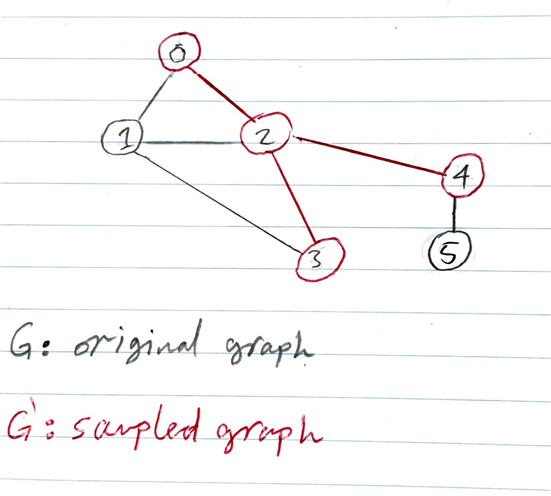

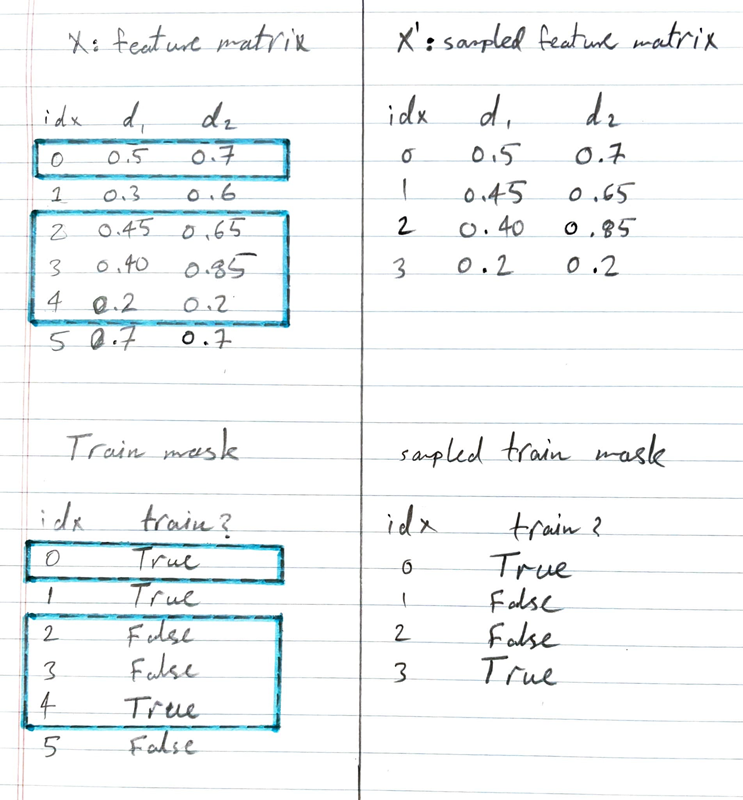

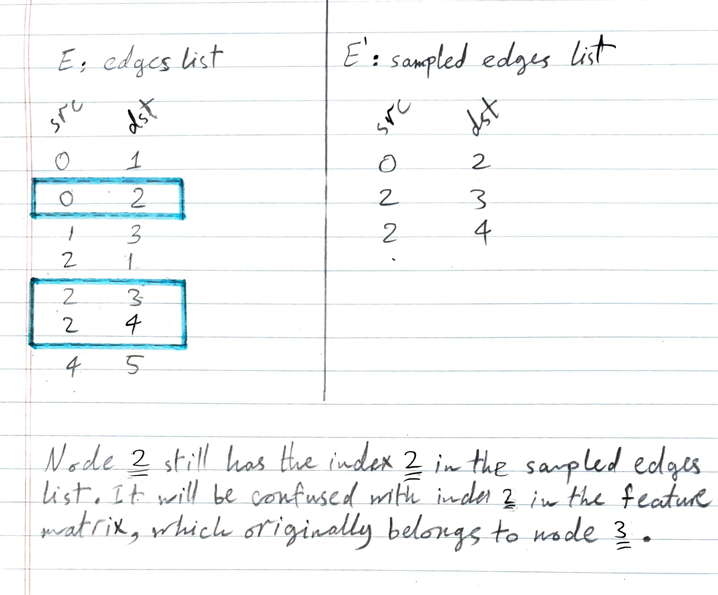

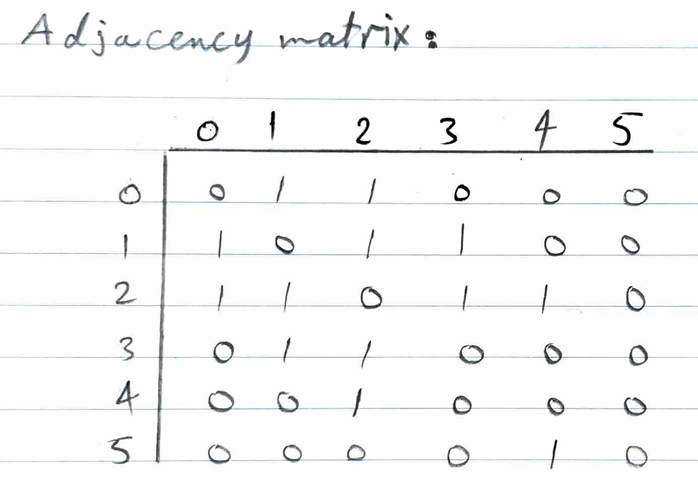

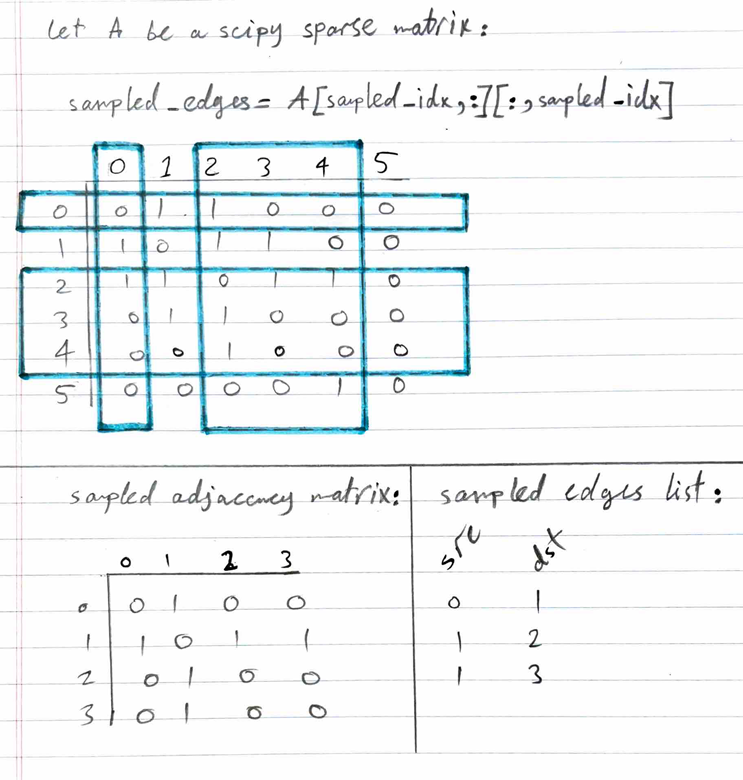

## Install METIS

In [ ]:
# credit to this answer on stackoverflow
# https://stackoverflow.com/questions/73860660/metis-installation-on-google-colab

import requests
import tarfile

# Download and extract the file from the official website
url = "http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/metis-5.1.0.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

# steps to install metis
%cd metis-5.1.0
!make config shared=1 prefix=~/.local/
!make install
!cp ~/.local/lib/libmetis.so /usr/lib/libmetis.so
!export METIS_DLL=/usr/lib/libmetis.so
!pip3 install metis-python

import metispy as metis

/content/metis-5.1.0
rm -rf build/Linux-x86_64
mkdir -p build/Linux-x86_64
cd build/Linux-x86_64 && cmake /content/metis-5.1.0 -DCMAKE_VERBOSE_MAKEFILE=1 -DGKLIB_PATH=/content/metis-5.1.0/GKlib -DCMAKE_INSTALL_PREFIX=/root/.local/ -DSHARED=1
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX comp

## Import libraries

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# install jraph
!pip install git+https://github.com/deepmind/jraph.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-ssglyjc7
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-ssglyjc7
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
  Created wheel for jraph: filename=jraph-0.0.6.dev0-py3-none-any.whl size=91246 sha256=f72829854651ffb29114ac9487d291f8aa822844ded707774859b78a15a74b0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-a77qyrnb/wheels/76/61/34/8fb9aa4dac00d471de4a5f7157614181de683c445fc2d640db
Successfully built jraph


In [ ]:
# Standard libraries
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import random
import itertools
from typing import Any, NamedTuple, Iterable, Mapping, Union, Optional

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx

# jax
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import flax
import flax.linen as nn
from flax.training import train_state
import optax
import pickle

# jraph
import jraph
from jraph._src import models as jraph_models

# PyTorch geometric
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
random_seed = 42
random.seed(random_seed)
key = jax.random.PRNGKey(random_seed)
torch_geometric.seed_everything(random_seed)
plt.style.use('dark_background')
colors = cm.tab10.colors
accuracy_list = []

## Create A Toy Graph

In [ ]:
edges = jax.random.randint(key, (150,2), 0, 50)
features = jax.random.uniform(key, shape=(50,2))

In [ ]:
adj = sp.sparse.csr_matrix((np.ones((edges.shape[0]), dtype=np.float32), (edges[:, 0], edges[:, 1])), shape=(features.shape[0], features.shape[0]))
adj += adj.transpose()
adj_lil = adj.tolil()

adj_lists = [[] for _ in range(features.shape[0])]
print(adj_lists)
for i in range(features.shape[0]):
  rows = adj_lil[i].rows[0]
  # self-edge needs to be removed for valid format of METIS
  if i in rows:
    rows.remove(i)
  adj_lists[i] = rows

print(adj_lists)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[2, 20, 21, 22, 26, 46], [6, 7, 14, 15, 16, 31, 48], [0, 13, 14, 20, 23, 24, 33, 35], [24, 32, 34, 40, 45], [5, 9, 14, 15, 32, 33, 41, 46, 49], [4, 21, 27, 37, 39], [1, 7, 11, 15, 16, 24, 28, 30, 37, 42], [1, 6, 22, 40, 42], [18, 22, 25, 29, 46], [4, 11, 14, 44], [32], [6, 9, 21, 26, 33, 45], [20, 22, 33], [2, 41, 42, 46], [1, 2, 4, 9, 21, 24, 29, 30, 38, 45], [1, 4, 6, 19, 36, 37, 40, 44], [1, 6, 19, 32, 36, 37], [20, 21, 22, 24, 31, 36, 49], [8, 37], [15, 16, 26, 33, 38], [0, 2, 12, 17, 26, 36], [0, 5, 11, 14, 17, 25, 28, 43, 49], [0, 7, 8, 12, 17, 28, 40, 48, 49], [2, 30, 34, 39, 42], [2, 3, 6, 14, 17, 34], [8, 21, 29], [0, 11, 19, 20, 34], [5, 41, 43], [6, 21, 22, 36], [8, 14, 25], [6, 14, 23, 38, 40, 44], [1, 17, 33, 34, 36, 39, 42, 48], [3, 4, 10, 16, 36], [2, 4, 11, 12, 19, 31, 36

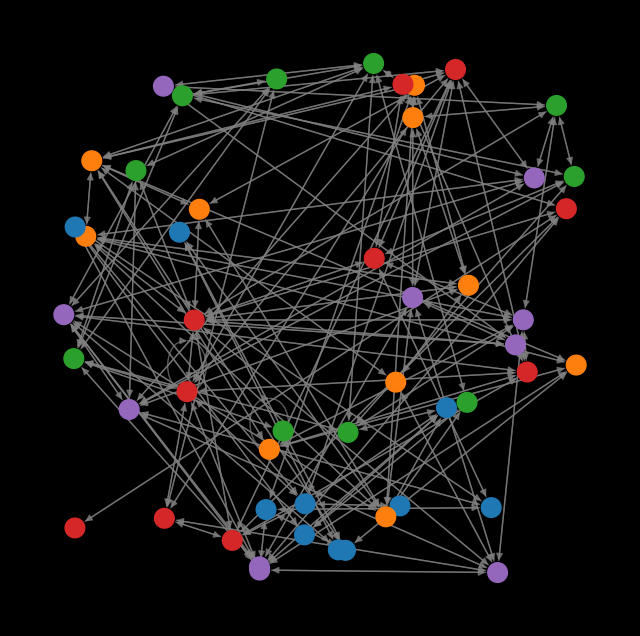

In [ ]:
_, groups = metis.part_graph(adj_lists, 5, seed=random_seed)
nodes_colors = np.array(colors)[groups]

G = nx.from_scipy_sparse_array(adj, create_using=nx.DiGraph)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=features, node_size=200, node_color=nodes_colors)
nx.draw_networkx_edges(G, pos=features, edge_color="grey", alpha=0.7)
plt.show()

## `partition_graph` Function

In [ ]:
GraphsInfo = NamedTuple('GraphsInfo', [('global_idx', int), ('train_mask', bool), ('val_mask', bool), ('test_mask', bool), ('y', int), ('one_hot_labels', int)])

In [ ]:
def partition_graph(edges, features, num_parts, num_parts_per_subgraph,
                    graph_train_mask, graph_val_mask, graph_test_mask,
                    graph_labels, one_hot_labels,):
  """partition a graph by METIS."""

  graphs_list     = []
  graphinfo_list  = []

  num_all_nodes = features.shape[0]
  adj = sp.sparse.csr_matrix((np.ones((edges.shape[0]), dtype=np.float32), (edges[:, 0], edges[:, 1])), shape=(num_all_nodes, num_all_nodes))
  adj += adj.transpose()
  adj_lil = adj.tolil()

  adj_lists = [[] for _ in range(num_all_nodes)]
  for i in range(num_all_nodes):
    rows = adj_lil[i].rows[0]
    # self-edge needs to be removed for valid format of METIS
    if i in rows:
      rows.remove(i)
    adj_lists[i] = rows


  _, groups = metis.part_graph(adj_lists, num_parts, seed=random_seed)

  part_row   = []
  part_col   = []
  part_data  = []
  parts = [[] for _ in range(num_parts)]

  for nd_idx in range(num_all_nodes):
    gp_idx = groups[nd_idx]
    parts[gp_idx].append(nd_idx)
    for nb_idx in adj[nd_idx].indices:
      if groups[nb_idx] == gp_idx:
        part_data.append(1)
        part_row.append(nd_idx)
        part_col.append(nb_idx)

  part_data.append(0)
  part_row.append(num_all_nodes - 1)
  part_col.append(num_all_nodes - 1)
  part_adj = sp.sparse.coo_matrix((part_data, (part_row, part_col))).tocsr()

  global_idx        = []
  features_batches  = []
  adj_batches       = []
  if graph_train_mask is not None:
    graph_train_mask_batches  = []
    graph_val_mask_batches    = []
    graph_test_mask_batches   = []
    graph_labels_batches      = []
    one_hot_labels_batches    = []

  for i in range(0, len(parts), num_parts_per_subgraph):
    if len(parts) - i < num_parts_per_subgraph:
      continue
    parts_merged = list(itertools.chain(*parts[i:i + num_parts_per_subgraph]))
    global_idx.append(parts_merged)
    features_batches.append(features[parts_merged,:])
    adj_batches.append(part_adj[parts_merged, :][:, parts_merged])

    if graph_train_mask is not None:
      graph_train_mask_batches.append(graph_train_mask[jnp.asarray(parts_merged, dtype=jnp.int32)])
      graph_val_mask_batches.append(graph_val_mask[jnp.asarray(parts_merged, dtype=jnp.int32)])
      graph_test_mask_batches.append(graph_test_mask[jnp.asarray(parts_merged, dtype=jnp.int32)])
      graph_labels_batches.append(graph_labels[jnp.asarray(parts_merged, dtype=jnp.int32)])
      one_hot_labels_batches.append(one_hot_labels[jnp.asarray(parts_merged, dtype=jnp.int32),:])

  for i in range(len(adj_batches)):
    graph = jraph.GraphsTuple(
        n_node=jnp.asarray([features_batches[i].shape[0]]),
        n_edge=jnp.asarray([adj_batches[i].nnz]),
        nodes=features_batches[i],
        edges=None,
        globals=None,
        senders=jnp.asarray(adj_batches[i].tocoo().row),
        receivers=jnp.asarray(adj_batches[i].tocoo().col))
    graphs_list.append(graph)

    if graph_train_mask is not None:
      graphinfo = GraphsInfo(global_idx=global_idx[i],
                             train_mask=graph_train_mask_batches[i],
                             val_mask=graph_val_mask_batches[i],
                             test_mask=graph_test_mask_batches[i],
                             y=graph_labels_batches[i],
                             one_hot_labels=one_hot_labels_batches[i])
      graphinfo_list.append(graphinfo)
    else:
      graphinfo = GraphsInfo(global_idx=global_idx[i],
                             train_mask=None,
                             val_mask=None,
                             test_mask=None,
                             y=None,
                             one_hot_labels=None)
      graphinfo_list.append(graphinfo)


  print(f'Number of nodes:          {num_all_nodes}')
  print(f'Number of edges:          {adj.nnz}')
  print(f'Number of edges part:     {part_adj.nnz}')
  print(f'Number of partitions:     {len(parts)}')
  print(f'Number of batches:        {len(adj_batches)}')

  return graphs_list, graphinfo_list

## Test `partition_graph` function with `num_parts=5` and `num_parts_per_subgraph=2`

Number of nodes:          50
Number of edges:          280
Number of edges part:     151
Number of partitions:     5
Number of batches:        2


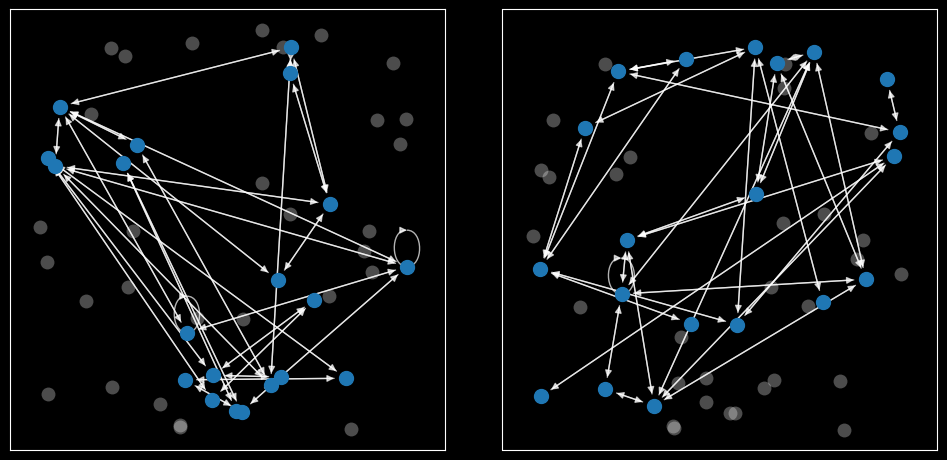

In [ ]:
graphs_list, _ = partition_graph(edges=edges, features=features,
                              num_parts=5, num_parts_per_subgraph=2,
                              graph_train_mask=None, graph_val_mask=None,
                              graph_test_mask=None, graph_labels=None,
                              one_hot_labels=None,)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
axs = axs.flatten()

for i, graph in enumerate(graphs_list):

  A_sample = sp.sparse.csr_array((jnp.ones((graph.senders.shape[0],1)).squeeze(),
                          (graph.senders, graph.receivers)),
                          shape=(graph.nodes.shape[0], graph.nodes.shape[0]))
  G_sample = nx.from_scipy_sparse_array(A_sample, create_using=nx.DiGraph)
  node_pos=graph.nodes
  nx.draw_networkx_nodes(G_sample, pos=node_pos, node_size=100, node_color='#1f77b4', ax = axs[i])
  nx.draw_networkx_edges(G_sample, pos=node_pos, edge_color="white", alpha=0.7, ax=axs[i])
  axs[i].scatter(features[:,0], features[:,1], marker='o', s=100, alpha=0.3, c='white', linewidth=0)

plt.show()

## Test `partition_graph` function with `num_parts=10` and `num_parts_per_subgraph=2`

Number of nodes:          50
Number of edges:          280
Number of edges part:     87
Number of partitions:     10
Number of batches:        5


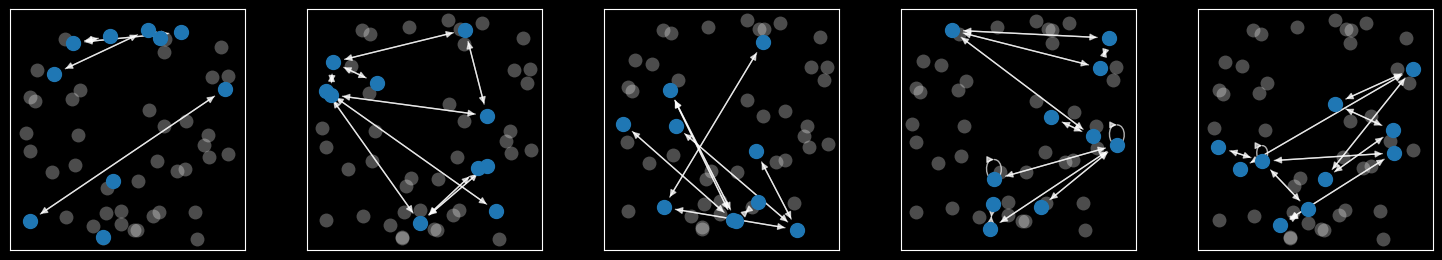

In [ ]:
graphs_list, _ = partition_graph(edges=edges, features=features,
                              num_parts=10, num_parts_per_subgraph=2,
                              graph_train_mask=None, graph_val_mask=None,
                              graph_test_mask=None, graph_labels=None,
                              one_hot_labels=None,)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()
axs = axs.flatten()

for i, graph in enumerate(graphs_list):

  A_sample = sp.sparse.csr_array((jnp.ones((graph.senders.shape[0],1)).squeeze(),
                          (graph.senders, graph.receivers)),
                          shape=(graph.nodes.shape[0], graph.nodes.shape[0]))
  G_sample = nx.from_scipy_sparse_array(A_sample, create_using=nx.DiGraph)
  node_pos=graph.nodes
  nx.draw_networkx_nodes(G_sample, pos=node_pos, node_size=100, node_color='#1f77b4', ax = axs[i])
  nx.draw_networkx_edges(G_sample, pos=node_pos, edge_color="white", alpha=0.7, ax=axs[i])
  axs[i].scatter(features[:,0], features[:,1], marker='o', s=100, alpha=0.3, c='white', linewidth=0)

plt.show()

## Import Cora Dataset

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# some statistics about the graph.
print(f'Number of nodes:          {data_Cora.num_nodes}')
print(f'Number of edges:          {data_Cora.num_edges}')
print(f'Average node degree:      {data_Cora.num_edges / data_Cora.num_nodes:.2f}')
print(f'Number of training nodes: {data_Cora.train_mask.sum()}')
print(f'Training node label rate: {int(data_Cora.train_mask.sum()) / data_Cora.num_nodes:.3f}')
print(f'Has isolated nodes:       {data_Cora.has_isolated_nodes()}')
print(f'Has self-loops:           {data_Cora.has_self_loops()}')
print(f'Is undirected:            {data_Cora.is_undirected()}')

Number of nodes:          2708
Number of edges:          10556
Average node degree:      3.90
Number of training nodes: 140
Training node label rate: 0.052
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_Cora.x.shape[0]]),
      n_edge=jnp.asarray([data_Cora.edge_index.shape[1]]),
      nodes=jnp.asarray(data_Cora.x),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_Cora.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_Cora.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_Cora.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_Cora.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_Cora.test_mask]).squeeze()
graph_labels = jnp.asarray([data_Cora.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')
print(f'Feature matrix data type: {graph.nodes.dtype}')
print(f'senders list data type:   {graph.senders.dtype}')
print(f'receivers list data type: {graph.receivers.dtype}')
print(f'Labels matrix data type:  {graph_labels.dtype}')

Number of nodes: 2708
Number of edges: 10556
Feature matrix data type: float32
senders list data type:   int32
receivers list data type: int32
Labels matrix data type:  int32


## GCN Layers from Jraph

In [ ]:
# Functions must be passed to jraph GNNs, but pytype does not recognise
# linen Modules as callables to here we wrap in a function.
def make_embed_fn(latent_size):
  def embed(inputs):
    return nn.Dense(latent_size)(inputs)
  return embed

def _attention_logit_fn(sender_attr: jnp.ndarray,
                        receiver_attr: jnp.ndarray,
                        edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return nn.Dense(1)(x)

In [ ]:
class GCN(nn.Module):
  """Defines a GAT network using FLAX

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gcn1_output_dim: int
  output_dim: int

  @nn.compact
  def __call__(self, x):
    gcn1 = jraph.GraphConvolution(update_node_fn=lambda n: jax.nn.relu(make_embed_fn(self.gcn1_output_dim)(n)),
                          add_self_edges=True)
    gcn2 = jraph.GraphConvolution(update_node_fn=nn.Dense(self.output_dim))
    return gcn2(gcn1(x))

In [ ]:
model = GCN(8, len(jnp.unique(graph_labels)))
model

GCN(
    # attributes
    gcn1_output_dim = 8
    output_dim = 7
)

## Optimizer and Loss
We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def compute_loss(state, params, graph, labels, one_hot_labels, mask):
  """Computes loss."""
  pred_graph = state.apply_fn(params, graph)
  preds = jax.nn.log_softmax(pred_graph.nodes)
  loss = optax.softmax_cross_entropy(preds, one_hot_labels)
  loss_mask = jnp.sum(jnp.where(mask, loss, 0)) / jnp.sum(mask)

  pred_labels = jnp.argmax(preds, axis=1)
  acc = (pred_labels == labels)
  acc_mask = jnp.sum(jnp.where(mask, acc, 0)) / jnp.sum(mask)
  return loss_mask, acc_mask

## Training on a full batch

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, graph, graph_labels, one_hot_labels, train_mask):
  # Gradient function
  grad_fn = jax.value_and_grad(compute_loss,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, graph, graph_labels, one_hot_labels, train_mask)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [ ]:
def train_model(state, graph, graph_labels, one_hot_labels, train_mask, val_mask, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, loss, acc = train_step(state, graph, graph_labels, one_hot_labels, train_mask)
    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}')
  return state, acc

In [ ]:
trained_model_state, train_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=200)
accuracy_list.append(['full batch', 'train', float(train_acc)])

step: 000, train loss: 1.9460, train acc: 0.1357
step: 001, train loss: 1.9413, train acc: 0.2429
step: 002, train loss: 1.9360, train acc: 0.2786
step: 003, train loss: 1.9289, train acc: 0.2786
step: 004, train loss: 1.9208, train acc: 0.2286
step: 005, train loss: 1.9126, train acc: 0.1786
step: 006, train loss: 1.9045, train acc: 0.1857
step: 007, train loss: 1.8962, train acc: 0.2286
step: 008, train loss: 1.8875, train acc: 0.2786
step: 009, train loss: 1.8783, train acc: 0.2929
step: 010, train loss: 1.8685, train acc: 0.3071
step: 011, train loss: 1.8582, train acc: 0.3357
step: 012, train loss: 1.8474, train acc: 0.3643
step: 013, train loss: 1.8362, train acc: 0.3786
step: 014, train loss: 1.8245, train acc: 0.3786
step: 015, train loss: 1.8123, train acc: 0.3786
step: 016, train loss: 1.7997, train acc: 0.3786
step: 017, train loss: 1.7866, train acc: 0.3786
step: 018, train loss: 1.7729, train acc: 0.3929
step: 019, train loss: 1.7587, train acc: 0.4143
step: 020, train los

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['full batch', 'test', float(test_acc)])

test loss: 0.7673, test acc: 0.7660


## Creating mini batches

In [ ]:
graphs_list, graphinfo_list = partition_graph(edges=jnp.concatenate((jnp.expand_dims(graph.senders,0), jnp.expand_dims(graph.receivers,0)), axis=0).T,
                                              features=graph.nodes, num_parts=32,
                                              num_parts_per_subgraph=8, graph_train_mask=graph_train_mask,
                                              graph_val_mask=graph_val_mask, graph_test_mask=graph_test_mask,
                                              graph_labels=graph_labels, one_hot_labels=one_hot_labels)

Number of nodes:          2708
Number of edges:          10556
Number of edges part:     8549
Number of partitions:     32
Number of batches:        4


In [ ]:
for i, subgraph in enumerate(graphs_list):
  print(f'Subgraph: {i:02d}, feature matrix: {subgraph.nodes.shape}, senders: {subgraph.senders.shape}, receivers: {subgraph.receivers.shape}')

Subgraph: 00, feature matrix: (675, 1433), senders: (2165,), receivers: (2165,)
Subgraph: 01, feature matrix: (680, 1433), senders: (2282,), receivers: (2282,)
Subgraph: 02, feature matrix: (680, 1433), senders: (2202,), receivers: (2202,)
Subgraph: 03, feature matrix: (673, 1433), senders: (1900,), receivers: (1900,)


## Make sure everything works as expected

In [ ]:
def test_graph_partition(graph, graphinfo_list, batch_id, test_node_local_id):
  test_node_global_id = graphinfo_list[batch_id].global_idx[test_node_local_id]
  print(f'batch id: {batch_id}, test node local id: {test_node_local_id}, test node global id: {test_node_global_id}')
  print('test node in global edge index:')
  print(graph.senders[(graph.senders == test_node_global_id)])
  print(graph.receivers[(graph.senders == test_node_global_id)])
  local_edge_index = jnp.vstack((graphs_list[batch_id].senders, graphs_list[batch_id].receivers))
  print('test node in local edge index:')
  print(local_edge_index[:, (local_edge_index[0, :] == test_node_local_id)])
  local_edge_index_receivers = local_edge_index[1, (local_edge_index[0, :] == test_node_local_id)]
  print('receivers in global edge index:')
  for i in local_edge_index_receivers:
    print(graphinfo_list[batch_id].global_idx[i], end=' ')

  print()
  print('test node global features:')
  print(graph.nodes[test_node_global_id,:10])
  print('test node local features:')
  print(graphs_list[batch_id].nodes[test_node_local_id,:10])

  print(f'test node globals: label= {graph_labels[test_node_global_id]}, train= {graph_train_mask[test_node_global_id]}')
  print(f'test node locals:  label= {graphinfo_list[batch_id].y[test_node_local_id]}, train= {graphinfo_list[batch_id].train_mask[test_node_local_id]} ')

test_graph_partition(graph, graphinfo_list, batch_id=0, test_node_local_id=0)
print()
test_graph_partition(graph, graphinfo_list, batch_id=1, test_node_local_id=300)
print()
test_graph_partition(graph, graphinfo_list, batch_id=2, test_node_local_id=200)
print()
test_graph_partition(graph, graphinfo_list, batch_id=3, test_node_local_id=400)

batch id: 0, test node local id: 0, test node global id: 8
test node in global edge index:
[8 8 8]
[ 269  281 1996]
test node in local edge index:
[[ 0  0  0]
 [ 3  4 54]]
receivers in global edge index:
269 281 1996 
test node global features:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
test node local features:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
test node globals: label= 3, train= True
test node locals:  label= 3, train= True 

batch id: 1, test node local id: 300, test node global id: 1547
test node in global edge index:
[1547]
[2169]
test node in local edge index:
[[300]
 [321]]
receivers in global edge index:
2169 
test node global features:
[0.         0.         0.04761905 0.         0.         0.
 0.         0.         0.         0.        ]
test node local features:
[0.         0.         0.04761905 0.         0.         0.
 0.         0.         0.         0.        ]
test node globals: label= 1, train= False
test node locals:  label= 1, train= False 

batch id: 2, test node local id: 200, 

## Training on mini batches

In [ ]:
def train_model_batch(state, graphs_list, graphinfo_list, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    for i, (graph, graphinfo) in enumerate(zip(graphs_list, graphinfo_list)):
      state, loss, acc = train_step(state, graph, graphinfo.y, graphinfo.one_hot_labels, graphinfo.train_mask)

    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}')
  return state, acc

In [ ]:
trained_model_state, train_acc = train_model_batch(model_state, graphs_list, graphinfo_list, num_epochs=200)
accuracy_list.append(['mini batch', 'train', float(train_acc)])

step: 000, train loss: 1.9539, train acc: 0.0732
step: 001, train loss: 1.9542, train acc: 0.0732
step: 002, train loss: 1.9502, train acc: 0.0732
step: 003, train loss: 1.9444, train acc: 0.0732
step: 004, train loss: 1.9365, train acc: 0.0732
step: 005, train loss: 1.9260, train acc: 0.1220
step: 006, train loss: 1.9135, train acc: 0.1220
step: 007, train loss: 1.8995, train acc: 0.1463
step: 008, train loss: 1.8838, train acc: 0.1463
step: 009, train loss: 1.8659, train acc: 0.2195
step: 010, train loss: 1.8453, train acc: 0.3659
step: 011, train loss: 1.8209, train acc: 0.3659
step: 012, train loss: 1.7938, train acc: 0.3659
step: 013, train loss: 1.7653, train acc: 0.3659
step: 014, train loss: 1.7353, train acc: 0.3659
step: 015, train loss: 1.7021, train acc: 0.3659
step: 016, train loss: 1.6648, train acc: 0.3659
step: 017, train loss: 1.6265, train acc: 0.3659
step: 018, train loss: 1.5850, train acc: 0.3659
step: 019, train loss: 1.5406, train acc: 0.3659
step: 020, train los

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['mini batch', 'test', float(test_acc)])

test loss: 0.7264, test acc: 0.7850


## Plotting the results

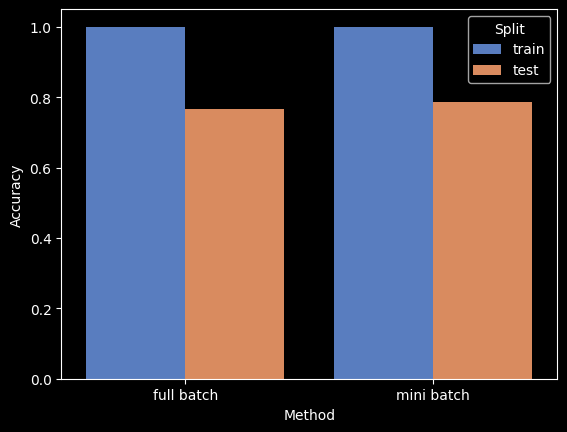

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Split', 'Accuracy'))
sns.barplot(df,x='Method', y='Accuracy', hue='Split', palette="muted")
plt.show()